Importing Libraries

In [1]:
import pandas as pd
from sentence_transformers import SentenceTransformer, util
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud


c:\Users\afrah khan\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Importing Dataset

In [2]:
df=pd.read_csv(r"C:\Users\afrah khan\Therapist\Therapist_Tagging_Final_Dataset.csv")
df.sample(5)

,Therapist Name,Response Style,Emotional Attunement,Modality Leaning,Handling of Resistance,Crisis Response,Feedback Openness,Power Sharing,Emotional Language Depth,Therapeutic Warmth,Safety vs Challenge,Specialties
8,Dr. Isaac Feldman,Directive,Moderate,Behavioral,Supportive,Action-Oriented,Open,Therapist-Led,Moderate,Neutral,Safe,"['Children', 'Parenting', 'ADHD']"
1,Dr. Eli Moreno,Exploratory,High,Psychodynamic,Gently Probing,Containment,Welcoming,Client-Led,Deep,Warm,Safe,"['Depression', 'Attachment', 'Self-Worth']"
3,Rev. Thomas Haines,Balanced,High,"Integrative, Spiritual",Supportive,Empathetic,Open,Collaborative,Deep,Warm,Safe,"['Grief', 'Spiritual Crisis', 'Couples']"
16,Chloe Wang,Balanced,Moderate,CBT,Supportive,Empathetic,Open,Collaborative,Moderate,Warm,Balanced,"['Anxiety', 'Perfectionism', 'Teen Therapy']"
12,Fatima Noor,Exploratory,High,Narrative,Gently Probing,Containment,Welcoming,Client-Led,Deep,Warm,Safe,"['Sexual Abuse', 'Self-Esteem', 'Loss']"


# Data Preprocessing

In [3]:
def preprocess(df):
    df = df.copy()
    df['Combined_Description'] = (
        df['Response Style'] + ' ' +
        df['Emotional Attunement'] + ' ' +
        df['Modality Leaning'] + ' ' +
        df['Handling of Resistance'] + ' ' +
        df['Crisis Response'] + ' ' +
        df['Feedback Openness'] + ' ' +
        df['Power Sharing'] + ' ' +
        df['Emotional Language Depth'] + ' ' +
        df['Therapeutic Warmth'] + ' ' +
        df['Safety vs Challenge']
    )
    df['Specialties'] = df['Specialties'].str.strip("[]").str.replace("'", "").str.replace(",", "")
    df['Full_Profile'] = df['Specialties'] + " " + df['Combined_Description']
    return df

In [4]:
df_cleaned = preprocess(df)

# EDA

In [5]:
df.dtypes

Therapist Name              object
Response Style              object
Emotional Attunement        object
Modality Leaning            object
Handling of Resistance      object
Crisis Response             object
Feedback Openness           object
Power Sharing               object
Emotional Language Depth    object
Therapeutic Warmth          object
Safety vs Challenge         object
Specialties                 object
dtype: object

In [6]:
df.columns

Index(['Therapist Name', 'Response Style', 'Emotional Attunement',
       'Modality Leaning', 'Handling of Resistance', 'Crisis Response',
       'Feedback Openness', 'Power Sharing', 'Emotional Language Depth',
       'Therapeutic Warmth', 'Safety vs Challenge', 'Specialties'],
      dtype='object')

C:\Users\afrah khan\AppData\Local\Temp\ipykernel_18804\2068410582.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(spec_names), y=list(counts), palette="viridis")


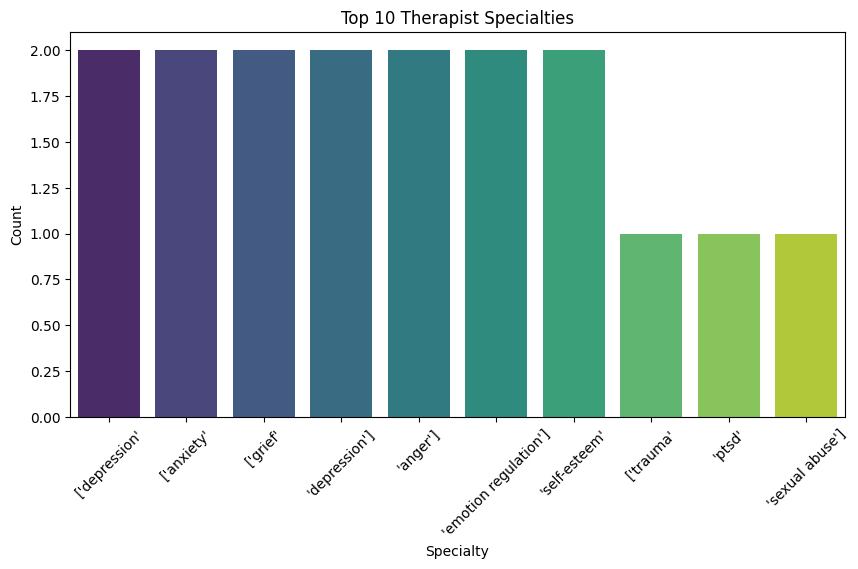

In [7]:
from collections import Counter

specialties = []
for entry in df['Specialties']:
    specialties.extend([s.strip().lower() for s in str(entry).split(',') if s.strip()])

common_specs = Counter(specialties).most_common(10)
spec_names, counts = zip(*common_specs)

plt.figure(figsize=(10, 5))
sns.barplot(x=list(spec_names), y=list(counts), palette="viridis")
plt.xticks(rotation=45)
plt.title("Top 10 Therapist Specialties")
plt.ylabel("Count")
plt.xlabel("Specialty")
plt.show()

Distribution of Response Styles

C:\Users\afrah khan\AppData\Local\Temp\ipykernel_18804\62401341.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, y='Response Style', order=df['Response Style'].value_counts().index, palette='Blues_d')


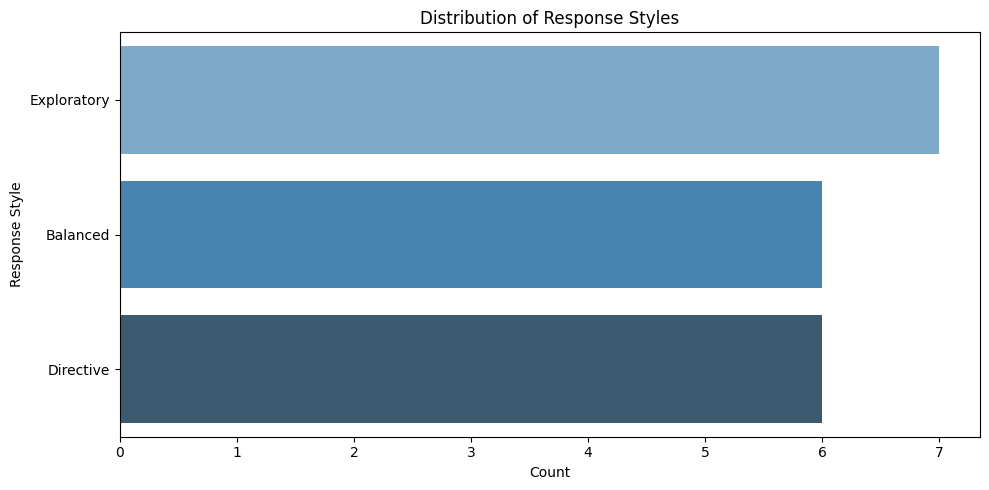

In [8]:
import seaborn as sns
plt.figure(figsize=(10,5))
sns.countplot(data=df, y='Response Style', order=df['Response Style'].value_counts().index, palette='Blues_d')
plt.title("Distribution of Response Styles")
plt.xlabel("Count")
plt.ylabel("Response Style")
plt.tight_layout()
plt.show()

Stacked Bar Plot: Emotional Language Depth vs Therapeutic Warmth

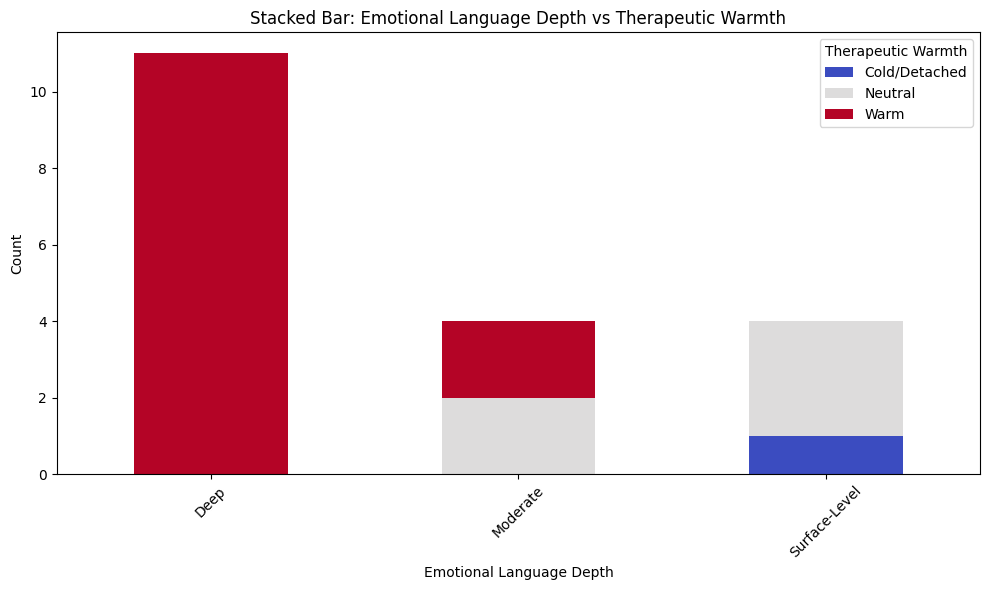

In [9]:
cross_tab = pd.crosstab(df['Emotional Language Depth'], df['Therapeutic Warmth'])

cross_tab.plot(kind='bar', stacked=True, colormap='coolwarm', figsize=(10,6))
plt.title("Stacked Bar: Emotional Language Depth vs Therapeutic Warmth")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Crisis Response Distribution

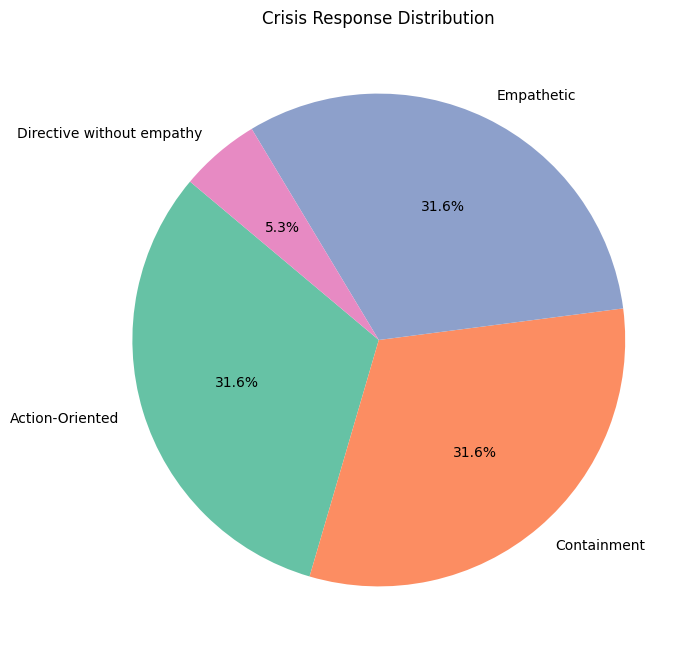

In [10]:
plt.figure(figsize=(8,8))
df['Crisis Response'].value_counts().plot.pie(autopct='%1.1f%%', startangle=140, colors=sns.color_palette("Set2"))
plt.title("Crisis Response Distribution")
plt.ylabel("")  # Hide y-label
plt.show()

# MODEL Training

In [11]:
model = SentenceTransformer('all-MiniLM-L6-v2')

In [12]:
therapist_embeddings = model.encode(df_cleaned['Full_Profile'].tolist(), convert_to_tensor=True)


Example

In [13]:
def suggest_therapists(problem, preference, df, model, corpus_embeddings):
    query = problem + ". " + preference
    query_embedding = model.encode(query, convert_to_tensor=True)
    cos_scores = util.pytorch_cos_sim(query_embedding, corpus_embeddings)[0]
    top_results = cos_scores.argsort(descending=True)[:3]

    suggestions = []
    for idx in top_results:
        i = idx.item()
        suggestions.append((
            df.iloc[i]['Therapist Name'],
            df.iloc[i]['Specialties'],
            round(cos_scores[i].item(), 4)
        ))
    return suggestions

In [14]:
def match_therapists_interactive(df, model, corpus_embeddings):
    print("\n🧠 Therapist Matching System")
    print("Please describe your issue and the kind of therapist you're looking for.")

    # Step 1: Get input from user
    problem = input("📝 What's troubling you? (e.g., I have anxiety and panic attacks):\n> ")
    preference = input("🎯 What kind of therapist do you prefer? (e.g., CBT-based, warm, listens deeply):\n> ")

    # Step 2: Create query
    query = problem + ". " + preference
    query_embedding = model.encode(query, convert_to_tensor=True)

    # Step 3: Get top matches
    cos_scores = util.pytorch_cos_sim(query_embedding, corpus_embeddings)[0]
    top_results = cos_scores.argsort(descending=True)[:3]

    # Step 4: Show matches
    print("\n🔍 Top 3 Therapist Matches:")
    for idx in top_results:
        i = idx.item()
        print(f"\n👤 Name: {df.iloc[i]['Therapist Name']}")
        print(f"💼 Specialties: {df.iloc[i]['Specialties']}")
        print(f"📊 Match Score: {cos_scores[i].item():.4f}")


In [16]:
match_therapists_interactive(df, model, therapist_embeddings)



🧠 Therapist Matching System
Please describe your issue and the kind of therapist you're looking for.

🔍 Top 3 Therapist Matches:

👤 Name: Ava Li, PsyD
💼 Specialties: ['BPD', 'Crisis Management', 'Emotion Regulation']
📊 Match Score: 0.3561

👤 Name: Chloe Wang
💼 Specialties: ['Anxiety', 'Perfectionism', 'Teen Therapy']
📊 Match Score: 0.3403

👤 Name: Dr. Maria Velasquez
💼 Specialties: ['Immigration Trauma', 'Cultural Identity', 'Anxiety']
📊 Match Score: 0.3298
